# 개 고양이 분류 - cnn v1
- 부분 데이터: 훈련 - 1000장씩/테스트 - 500장씩.
- 이미지 센터링 처리 X
- 

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
seed=2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [28]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip


--2022-05-24 05:59:09--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 142.250.99.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip.1’

cats_and_dogs_filte 100%[===================>]  65.43M   193MB/s    in 0.3s    

2022-05-24 05:59:09 (193 MB/s) - ‘cats_and_dogs_filtered.zip.1’ saved [68606236/68606236]



In [29]:
!unzip cats_and_dogs_filtered.zip > /dev/null

replace cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


- 데이터 탐색

In [30]:
train_dir = 'cats_and_dogs_filtered/train'
validation_dir = 'cats_and_dogs_filtered/validation'
train_cats_dir = 'cats_and_dogs_filtered/train/cats'
train_dogs_dir = 'cats_and_dogs_filtered/train/dogs'
validation_cats_dir = 'cats_and_dogs_filtered/validation/cats'
validation_dogs_dir = 'cats_and_dogs_filtered/validation/dogs'


In [31]:
#파일 이름
import os
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)

print(train_cats_fnames[:5])
print(train_dogs_fnames[:5])

['cat.264.jpg', 'cat.708.jpg', 'cat.381.jpg', 'cat.37.jpg', 'cat.281.jpg']
['dog.28.jpg', 'dog.874.jpg', 'dog.140.jpg', 'dog.862.jpg', 'dog.290.jpg']


In [32]:
#파일 갯수
len(train_cats_fnames), len(train_dogs_fnames)

(1000, 1000)

- 이미지 확인

In [33]:
fname= os.path.join(train_cats_dir,'cat.475.jpg')
fname

'cats_and_dogs_filtered/train/cats/cat.475.jpg'

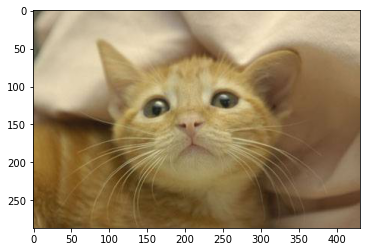

In [34]:
#1)pillow로 열기

from PIL import Image
img=Image.open(fname)
plt.imshow(img);

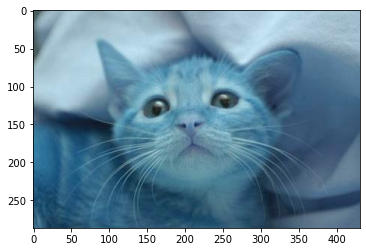

In [35]:
#2)opencv로 열기
import cv2 
img2 = cv2.imread(fname)
plt.imshow(img2); 
#BRG 순서로 이미지를 읽음.

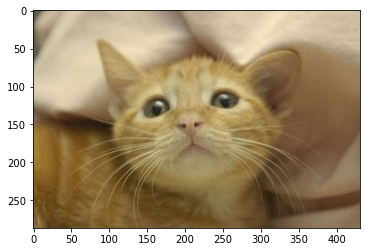

In [36]:
img2=img2[:,:,::-1]
plt.imshow(img2); 


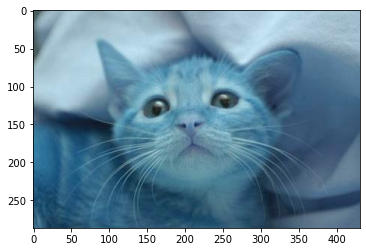

In [37]:
img3=cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img3); 


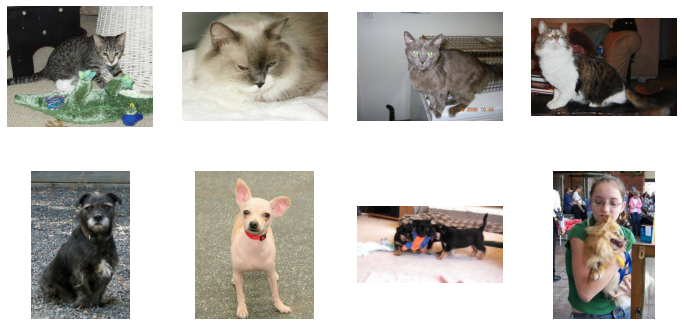

In [38]:
plt.figure(figsize=(12,6))
for i in range(4):
    plt.subplot(2,4,i+1)
    cat= cv2.imread(os.path.join(train_cats_dir,train_cats_fnames[i]))[:,:,::-1]
    plt.imshow(cat), plt.axis('off')
    plt.subplot(2,4,i+5)
    dog= cv2.imread(os.path.join(train_dogs_dir,train_dogs_fnames[i]))[:,:,::-1]
    plt.imshow(dog), plt.axis('off'),

In [39]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D,Flatten, MaxPooling2D, Dropout
#flatten - 3차원인 conv2D를 1차원인 dense, fully connected layer로 
#넣어야 하기 때문에 차원 축소를 할 때 필요.
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [40]:
model =Sequential([
                   Conv2D(16, kernel_size=(3,3), input_shape=(150,150,3),activation='relu'),
                   MaxPooling2D(), #= MaxPooling2D(pool_size=(2,2))
                    Conv2D(32, kernel_size=(3,3), input_shape=(150,150,3),activation='relu'),
                    MaxPooling2D(),
                    Conv2D(64, kernel_size=(3,3), input_shape=(150,150,3),activation='relu'),
                    MaxPooling2D(),
                   Flatten(), #24,24,64에서 1차원 512개의 노드로.
                   Dense(512,activation='relu'),
                   Dense(1,activation='sigmoid')
])
model.summary()

#18496=32 x 3 x 3 x 64 + 64

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 64)      

In [41]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001,decay=1e-8),
              loss='binary_crossentropy',metrics=['accuracy'])
model_path = 'best-cat-dog-v1.h5'
mc=ModelCheckpoint(model_path,save_best_only=True,verbose=1)
es=EarlyStopping(patience=10)

파일에서 이미지 데이터 읽어서 학습시키는 방법

In [42]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)#min-max scaler 같은 것.
test_datagen = ImageDataGenerator(rescale=1/255.)

In [43]:
train_generator= train_datagen.flow_from_directory(
    train_dir, batch_size=20, class_mode= 'binary',
    target_size=(150,150)
)

test_generator = test_datagen.flow_from_directory(
    validation_dir, batch_size=20, class_mode= 'binary',
    target_size=(150,150)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


모델 실행

In [44]:
hist=model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=100,
    steps_per_epoch= 100,
    validation_steps=50, 
    callbacks=[mc,es]
)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.7144 - accuracy: 0.5845
Epoch 1: val_loss improved from inf to 0.63494, saving model to best-cat-dog-v1.h5
100/100 [==============================] - 11s 97ms/step - loss: 0.7144 - accuracy: 0.5845 - val_loss: 0.6349 - val_accuracy: 0.6470
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.6149 - accuracy: 0.6750
Epoch 2: val_loss improved from 0.63494 to 0.61002, saving model to best-cat-dog-v1.h5
100/100 [==============================] - 9s 93ms/step - loss: 0.6149 - accuracy: 0.6750 - val_loss: 0.6100 - val_accuracy: 0.6600
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.5386 - accuracy: 0.7345
Epoch 3: val_loss did not improve from 0.61002
100/100 [==============================] - 9s 91ms/step - loss: 0.5386 - accuracy: 0.7345 - val_loss: 0.6118 - val_accuracy: 0.6880
Epoch 4/100
100/100 [==============================] - ETA: 0s - loss: 0.4529 - accuracy: 0.787

In [45]:
best_model = load_model(model_path)


- 테스트 이미지 분류

In [46]:
from google.colab import files
up=files.upload()

Saving 개.jpg to 개 (1).jpg
Saving 개1.jfif to 개1 (1).jfif
Saving 개2.jpg to 개2 (1).jpg
Saving 고양이.jpg to 고양이 (1).jpg
Saving 고양이1.jpg to 고양이1 (1).jpg
Saving 고양이2.jfif to 고양이2 (1).jfif


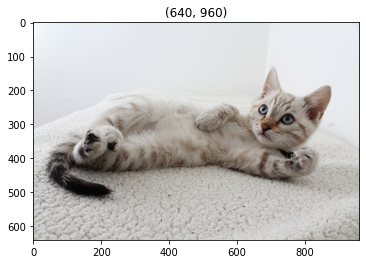

In [47]:
img=cv2.imread('고양이1.jpg')[:,:,::-1]
plt.imshow(img), plt.title(img.shape[:-1]);

In [48]:
# 150 x 150으로 바꾸기
img=cv2.resize(img,dsize=(150,150),interpolation=cv2.INTER_AREA)


In [49]:
best_model.predict(img.reshape(1,150,150,3))

array([[5.2451886e-21]], dtype=float32)

In [52]:
for fname in up.keys():
    img=cv2.imread(fname)[:,:,::-1]
    if sum(img.shape[:-1]) > 300:
        img=cv2.resize(img,dsize=(150,150),interpolation=cv2.INTER_AREA)
    else:
        img=cv2.resize(img,dsize=(150,150),interpolation=cv2.INTER_CUBIC)
#이미지가 큰 걸 줄일 땐 area, 작은 걸 키울 때는 cubic이라는 '보관법'을 쓴다.
    classes=best_model.predict(img.reshape(1,150,150,3))
    print(f"{classes[0,0]:.4f} {fname} is a {'dog' if classes[0,0]>0.5 else 'cat'}")


1.0000 개.jpg is a dog
1.0000 개1.jfif is a dog
1.0000 개2.jpg is a dog
0.0142 고양이.jpg is a cat
0.0000 고양이1.jpg is a cat
1.0000 고양이2.jfif is a dog


In [54]:

img=cv2.imread('/content/고양이333.jpg')[:,:,::-1]
if sum(img.shape[:-1]) > 300:
    img=cv2.resize(img,dsize=(150,150),interpolation=cv2.INTER_AREA)
else:
    img=cv2.resize(img,dsize=(150,150),interpolation=cv2.INTER_CUBIC)
#이미지가 큰 걸 줄일 땐 area, 작은 걸 키울 때는 cubic이라는 '보관법'을 쓴다.
classes=best_model.predict(img.reshape(1,150,150,3))
print(f"{classes[0,0]:.4f} {'고양이333'} is a {'dog' if classes[0,0]>0.5 else 'cat'}")


1.0000 고양이333 is a dog


In [55]:

img=cv2.imread('/content/71835_craw1.jpg')[:,:,::-1]
if sum(img.shape[:-1]) > 300:
    img=cv2.resize(img,dsize=(150,150),interpolation=cv2.INTER_AREA)
else:
    img=cv2.resize(img,dsize=(150,150),interpolation=cv2.INTER_CUBIC)
#이미지가 큰 걸 줄일 땐 area, 작은 걸 키울 때는 cubic이라는 '보관법'을 쓴다.
classes=best_model.predict(img.reshape(1,150,150,3))
print(f"{classes[0,0]:.4f} {'craw'} is a {'dog' if classes[0,0]>0.5 else 'cat'}")


1.0000 craw is a dog


In [ ]:
from tensorflow.keras.datasets import fashion_mnist
(X_train, y_train), (X_test,y_test) = fashion_mnist.load_data()
X_train.shape, y_train.shape,X_test.shape,y_test.shape

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
seed=2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [ ]:
#X_train, X_test 정규화 (0~1)
#이미지 차원 변경:CNN=2차원을 3차원으로 올려야.

X_train = X_train.reshape(-1,28,28,1) / 255.
X_test = X_test.reshape(-1,28,28,1) / 255.
X_train.shape, X_test.shape

In [ ]:
#원핫인코딩
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(y_train)
Y_test=to_categorical(y_test)
Y_train.shape,Y_test.shape


- 모델 정의/설정/학습/평가

In [ ]:
model.compile('adam','categorical_crossentropy',['accuracy'])

In [ ]:
model_path = 'best-fasion-mnist-cnn-v2.h5'
mc=ModelCheckpoint(model_path,save_best_only=True,verbose=1)
es=EarlyStopping(patience=10)

In [ ]:
hist=model.fit(X_train,Y_train,validation_split=0.2,
                 epochs=100,batch_size=200,verbose=0,
                 callbacks=[mc,es])

In [ ]:
best_model = load_model(model_path)
best_model.evaluate(X_test,Y_test)

In [ ]:
y_acc=hist.history['accuracy']
y_vloss=hist.history['val_loss']
xs=np.arange(1, len(y_acc)+1)
plt.figure(figsize=(20,8))
plt.plot(xs,y_acc,label='train accuracy1')
plt.plot(xs,y_vloss,label='val_loss1')
plt.legend(),
plt.grid(),
plt.xlabel('Epoch')